In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.array(magerr_ref1[mask], dtype=float)
n=len(x)
X = np.reshape(x,(n,1))


In [4]:
#We specify the prior distribution for the model parameters as normal distributions after the
#Kelly 2009 values. Kelly does write that the priors should be uniform, but the Stan people write that
#this is a bad idea and that something like a normal distributions should be used instead. 

#Sadly Skielboe et al. 2015 does not write up their priors for the model parameters.

#ℓ is related to ℓ_true by ℓ_true=2*ℓ^2, where ℓ_true is the typical timescale of variations.
#I use the result from Kelly 2009 where the range for ℓ_true is 10<ℓ_true<10^4 days with a true
#dispersion likely around 0.3 dex. I calculate the ℓ mean and sigma prior values from the ℓ_true values. 
#Maybe i should try a uniform prior here as well though the values found in Kelly 2009 are not uniform.

#η is what Skielboe et al. 2015 call σ and it is the long-term standard deviation. 
#Using a normal distribution with the mean as the standard deviation of the data and sigma as a guess.
#i get negative stdev values. i tried a uniform prior between 0 and 1 that seems to work. 
#A Halfnormal distribution also gives the same result.

#σ is the noise scale in the data such that if y is the observed values and f(x) is the underlying 
#unknown function, then y=f(x)+epsilon where the noise epsilon is Gaussian. 
#This value is the most confusing to me. 
#How do we determine the scale of the Gaussian white noise? Is it white noise at all for us?
#Kelly 2009 writes that there is a epsilon(t) white noise process with zero mean and variance equal
#to 1 and it is assumed that this process is also Gaussian. I apply a halfnormal distribution to the
#noise with the scale specified by the variance as sigma=sqrt(pi/(pi-2))*sqrt(Var) where Var=1 in our case.

#A uniform prior is given by something like pm.Uniform('parameter', lower=-10, upper=5)

with pm.Model() as model:
    ℓ = pm.Uniform('ℓ', lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))#multiply 6.0#pm.Normal("ℓ", mu=50.0, sigma=25.0) #the mean and sigma values here are rounded off. 
    η = pm.Uniform('η', lower=0.0, upper=1.0)#pm.Normal("η", mu=0.152154, sigma=0.072579)# #pm.HalfCauchy("η", beta=0.5)

    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Latent(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    f = gp.prior("f", X=X)
    
    k = pm.Uniform('k', lower=1.0, upper=10.0)

    y_ = pm.Normal("y", mu=f, sd=k*yerr, observed=y)

    trace = pm.sample(2000, cores=4) #try to do tuning first to improve sampling time?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [5]:
pm.summary(trace, ["k","ℓ","η"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
k,4.925220,0.913901,0.027479,3.227496,6.704993,981.188780,1.002343
ℓ,118.587486,49.983390,1.036733,42.459384,211.369804,2072.337489,1.000845
η,0.089763,0.022088,0.000585,0.052029,0.134438,1173.689887,1.004017


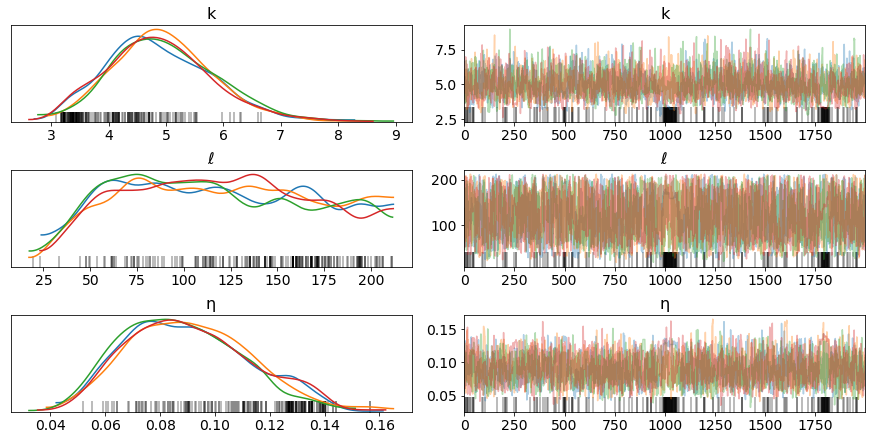

In [6]:
pm.traceplot(trace, var_names=["k","ℓ","η"]);

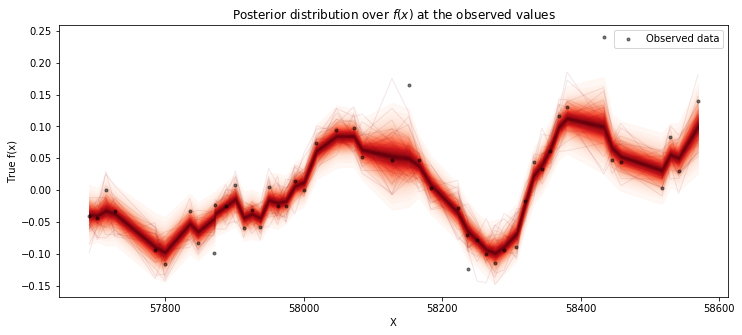

In [7]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [8]:
# 200 new values from x=0 to x=15
n_new = 100
X_new = np.linspace(min(X), max(X), n_new)

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:39<00:00, 28.39it/s]


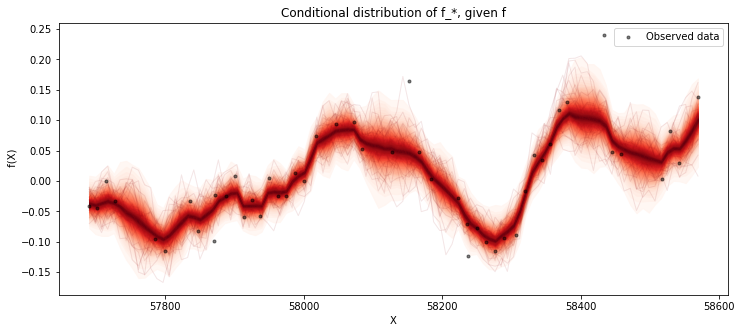

In [9]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel(" f(X)");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

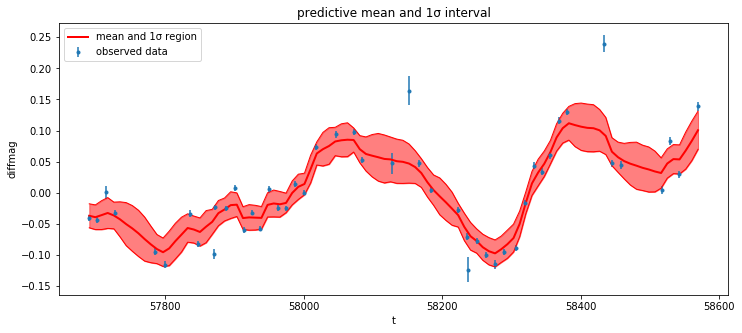

In [12]:
#Calculate the mean and standard deviation of the traces. 
muJ = np.zeros(len(X_new))
sdJ = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    muJ[i] = np.mean(pred_samples["f_pred"][:,i])
    sdJ[i] = np.std(pred_samples["f_pred"][:,i])

np.savetxt('Jband.txt',np.c_[X_new,muJ,sdJ],delimiter=',')

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, muJ, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, muJ + 1*sdJ, 'r', lw=1); plt.plot(X_new, muJ - 1*sdJ, 'r', lw=1);
plt.fill_between(X_new.flatten(), muJ - 1*sdJ, muJ + 1*sdJ, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();

 # This part fits the K-band   

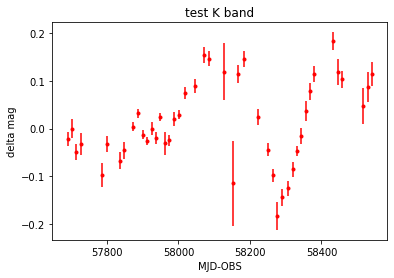

In [3]:
mask2 = (filt == 'K')

xK=np.asarray(mjd_obs[mask2], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
XK_new=np.linspace(min(XK),max(XK),100,dtype=np.float64)

yK=np.asarray(delta_mag_agn_ref1[mask2]-np.median(delta_mag_agn_ref1[mask2]), dtype=float)
yKerr = np.asarray(magerr_ref1[mask2], dtype=float)

plt.errorbar(mjd_obs[mask2], delta_mag_agn_ref1[mask2]-np.median(delta_mag_agn_ref1[mask2]), magerr_ref1[mask2],fmt='r.')
plt.title('test K band')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [10]:
with pm.Model() as modelK:
    ℓK = pm.Uniform('ℓK', lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))#multiply 6.0#pm.Normal("ℓ", mu=50.0, sigma=25.0) #the mean and sigma values here are rounded off. 
    ηK = pm.Uniform('ηK', lower=0.0, upper=1.0)#pm.Normal("η", mu=0.152154, sigma=0.072579)# #pm.HalfCauchy("η", beta=0.5)

    cov = ηK**2 * pm.gp.cov.Exponential(1, ℓK)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Latent(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    f = gp.prior("f", X=XK)
    
    kK = pm.Uniform('kK', lower=1.0, upper=10.0)

    y_ = pm.Normal("yK", mu=f, sd=kK*yKerr, observed=yK)

    traceK = pm.sample(2000, cores=4) #try to do tuning first to improve sampling time?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [11]:
pm.summary(traceK, ["kK","ℓK","ηK"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
kK,1.278196,0.221534,0.004338,1.000031,1.705737,2422.785113,1.000011
ℓK,55.098792,10.729449,0.126147,35.054584,70.700782,5502.386750,0.999875
ηK,0.080416,0.012130,0.000213,0.058217,0.105339,2673.103193,0.999842


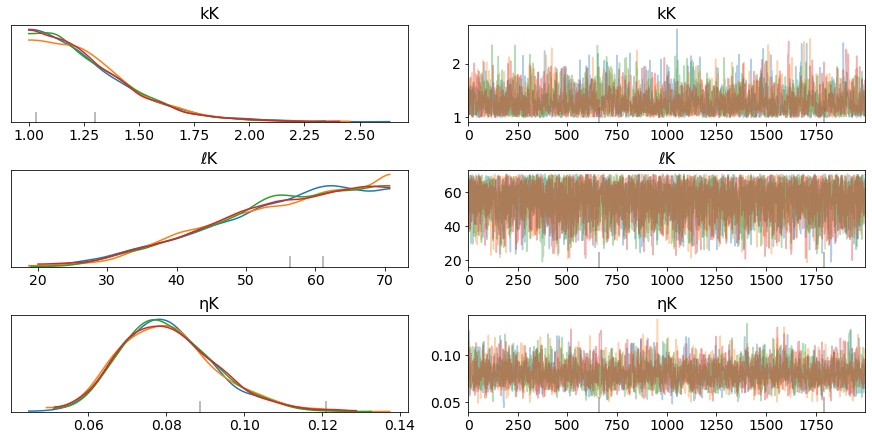

In [13]:
pm.traceplot(traceK, var_names=["kK","ℓK","ηK"]);

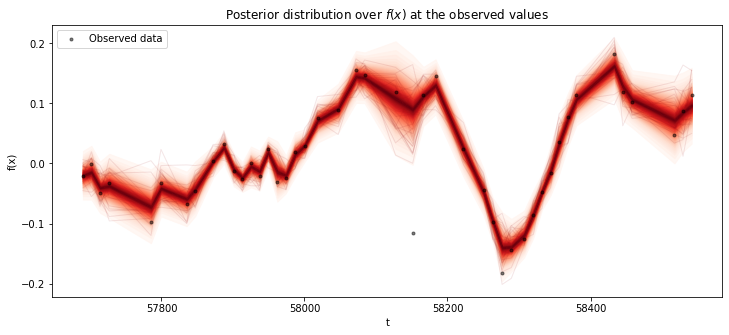

In [18]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, traceK["f"], XK);

# plot the data and the true latent function
plt.plot(XK, yK, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("t"); plt.ylabel("f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [14]:
# add the GP conditional to the model, given the X values
with modelK:
    f_pred = gp.conditional("f_pred", XK_new)
    
with modelK:
    pred_samples = pm.sample_posterior_predictive(traceK, vars=[f_pred], samples=1000)
#This function will randomly draw 1000 samples of parameters from the trace. Then, for each sample,
#it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample.

100%|██████████| 1000/1000 [00:40<00:00, 29.76it/s]


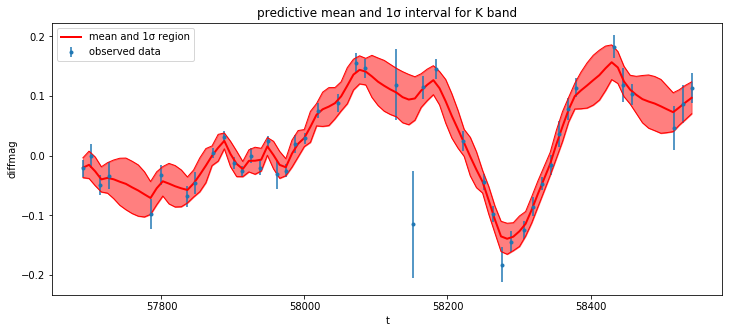

In [25]:
#Calculate the mean and standard deviation of the traces. 
muK = np.zeros(len(XK_new))
sdK = np.zeros(len(XK_new))
for i in range(0,len(XK_new)):
    muK[i] = np.mean(pred_samples["f_pred"][:,i])
    sdK[i] = np.std(pred_samples["f_pred"][:,i])

np.savetxt('Kband.txt',np.c_[XK_new,muK,sdK],delimiter=',')

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(XK_new, muK, 'r', lw=2, label="mean and 1σ region");
plt.plot(XK_new, muK + 1*sdK, 'r', lw=1); plt.plot(XK_new, muK - 1*sdK, 'r', lw=1);
plt.fill_between(XK_new.flatten(), muK - 1*sdK, muK + 1*sdK, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(XK, yK, yKerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval for K band"); plt.legend();

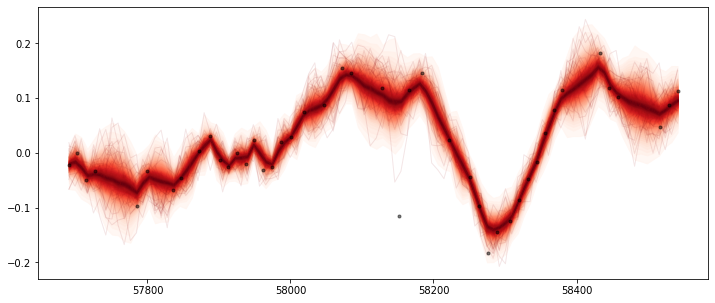

In [16]:
#Now, pred_samples contains 1000 generated data sets (containing 100 samples each),
#each using a different parameter setting from the posterior:

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], XK_new);

# plot the data
plt.plot(XK, yK, 'ok', ms=3, alpha=0.5, label="Observed data");

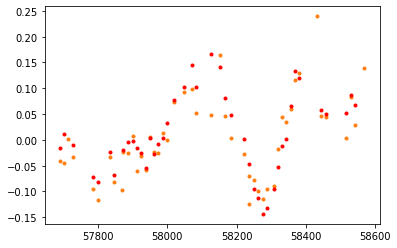

In [48]:
plt.plot(XK,yK,'*')
plt.plot(X,y,'.')
plt.plot(XH,yH,'.r')

## This is for the H-band

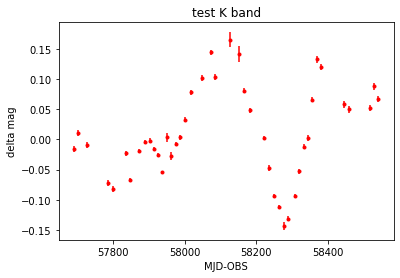

In [30]:
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,2)
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],2)
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,2)

plt.errorbar(xH, yH, yHerr,fmt='r.')
plt.title('test K band')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [31]:
with pm.Model() as modelH:
    ℓH = pm.Uniform('ℓH', lower=1.2574, upper=6.0*50.0*np.sqrt(2.0))#multiply 6.0#pm.Normal("ℓ", mu=50.0, sigma=25.0) #the mean and sigma values here are rounded off. 
    ηH = pm.Uniform('ηH', lower=0.0, upper=1.0)#pm.Normal("η", mu=0.152154, sigma=0.072579)# #pm.HalfCauchy("η", beta=0.5)

    cov = ηH**2 * pm.gp.cov.Exponential(1, ℓH)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Latent(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    fH = gp.prior("fH", X=XH)
    
    kH = pm.Uniform('kH', lower=1.0, upper=10.0)

    y_ = pm.Normal("yH", mu=fH, sd=kH*yHerr, observed=yH)

    traceH = pm.sample(2000, cores=4) #try to do tuning first to improve sampling time?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
kH,2.471148,0.792466,0.036469,1.259123,4.021815,381.890608,1.005358
ℓH,203.273545,106.350270,3.403305,46.760940,400.401626,766.086218,1.000750
ηH,0.120833,0.034724,0.001137,0.061508,0.186886,733.396038,1.001354


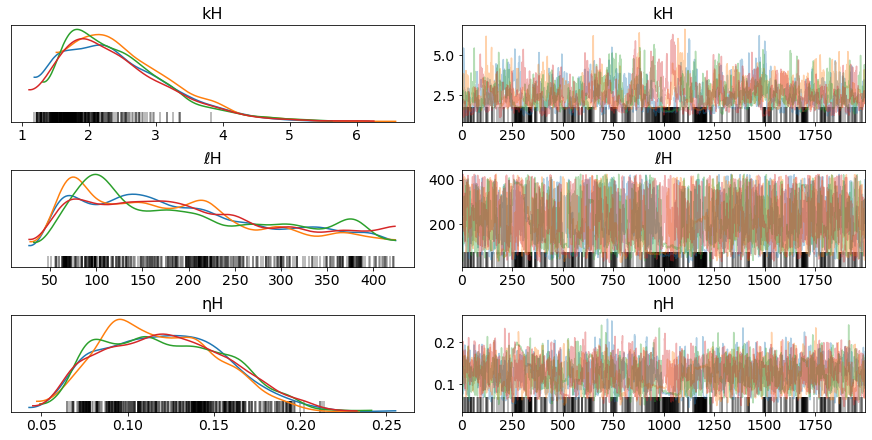

In [37]:
pm.traceplot(traceH,var_names=["kH","ℓH","ηH"])
pm.summary(traceH,var_names=["kH","ℓH","ηH"])

In [38]:
# add the GP conditional to the model, given the X values
with modelH:
    f_predH = gp.conditional("f_predH", XH_new)
    
with modelH:
    pred_samples = pm.sample_posterior_predictive(traceH, vars=[f_predH], samples=1000)
#This function will randomly draw 1000 samples of parameters from the trace. Then, for each sample,
#it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample.

100%|██████████| 1000/1000 [00:39<00:00, 30.12it/s]


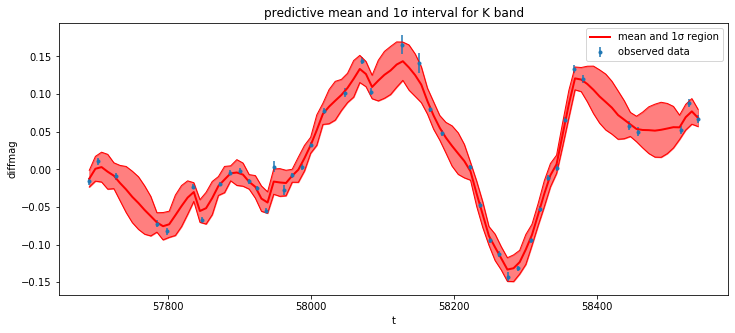

In [39]:
#Calculate the mean and standard deviation of the traces. 
muH = np.zeros(len(XH_new))
sdH = np.zeros(len(XH_new))
for i in range(0,len(XH_new)):
    muH[i] = np.mean(pred_samples["f_predH"][:,i])
    sdH[i] = np.std(pred_samples["f_predH"][:,i])

np.savetxt('Hband.txt',np.c_[XH_new,muH,sdH],delimiter=',')

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(XH_new, muH, 'r', lw=2, label="mean and 1σ region");
plt.plot(XH_new, muH + 1*sdH, 'r', lw=1); plt.plot(XH_new, muH - 1*sdH, 'r', lw=1);
plt.fill_between(XH_new.flatten(), muH - 1*sdH, muH + 1*sdH, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(XH, yH, yHerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval for K band"); plt.legend();

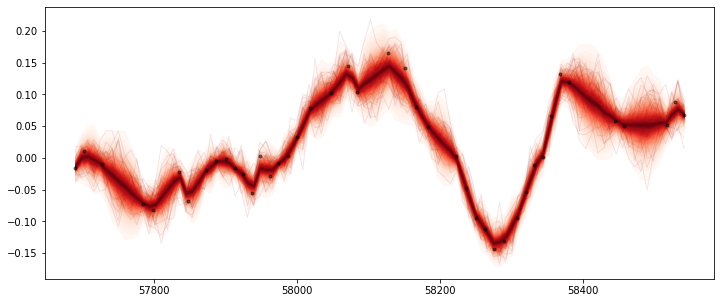

In [40]:
#Now, pred_samples contains 1000 generated data sets (containing 100 samples each),
#each using a different parameter setting from the posterior:

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_predH"], XH_new);

# plot the data
plt.plot(XH, yH, 'ok', ms=3, alpha=0.5, label="Observed data");